# Word embeddings for sentiment analysis

https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e

In [1]:
import os
from pathlib import Path
import sys

In [2]:
project_name = 'clpsych'
project_path = '/home/guerramarj/github/clpsych/'

if sys.platform == "win32":
    data_path = 'D:\Dataset\{0}\dataset'.format(project_name)
    model_path = 'D:\Dataset\{0}\models'.format(project_name)
    src_path = '/Volumes/Dataset/{0}/src'.format(project_name)
    
elif sys.platform == 'darwin':
    data_path = '/Volumes/Dataset/{0}/dataset'.format(project_name)
    model_path = '/Volumes/Dataset/{0}/models'.format(project_name)
    src_path = '/Volumes/Dataset/{0}/src'.format(project_name)
    
else:
    data_path = Path(project_path, 'dataset')
    model_path = Path(project_path, 'models')
    src_path = Path(project_path, 'src')

utils_path = str(Path(project_path, 'utils'))
# including the project folder and the utils folder
if utils_path not in ''.join(sys.path):
    sys.path.extend([str(project_path), utils_path, str(src_path)])

print('project path = {0}'.format(project_path))
print('data path = {0}'.format(data_path))
print('model path = {0}'.format(model_path))
print('sys.path = {0}'.format(sys.path))

project path = /home/guerramarj/github/clpsych/
data path = /home/guerramarj/github/clpsych/dataset
model path = /home/guerramarj/github/clpsych/models
sys.path = ['/cm/local/apps/cuda/libs/current/pynvml', '/home/guerramarj/python/Python-3.6.3', '/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python36.zip', '/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python3.6', '/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python3.6/lib-dynload', '', '/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python3.6/site-packages', '/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python3.6/site-packages/Mako-1.0.7-py3.6.egg', '/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python3.6/site-packages/IPython/extensions', '/home/guerramarj/.ipython', '/home/guerramarj/github/clpsych/', '/home/guerramarj/github/clpsych/utils', '/home/guerramarj/github/clpsych/src']


In [92]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

# wei
from data_helpers import build_vocab
from data_helpers import load_data_and_labels
from data_helpers import pad_sentences

In [27]:
def deep_model(model, x_train, y_train, x_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(x_train
                       , y_train
                       , epochs=number_epochs
                       , batch_size=batch_size
                       , validation_data=(x_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, number_epochs + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, x_train, y_train, x_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(x_train
              , y_train
              , epochs=epoch_stop
              , batch_size=batch_size
              , verbose=0)
    results = model.evaluate(x_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1 and ] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [119]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            processed_tweet.append(word)

    return ' '.join(processed_tweet)


def preprocess_csv(csv_file_name, processed_file_name, test_file=False):
    save_to_file = open(processed_file_name, 'w')

    with open(csv_file_name, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            tweet_id = line[:line.find(',')]
            if not test_file:
                line = line[1 + line.find(','):]
                positive = int(line[:line.find(',')])
            line = line[1 + line.find(','):]
            tweet = line
            processed_tweet = preprocess_tweet(tweet)
            if not test_file:
                save_to_file.write('%s,%d,%s\n' %
                                   (tweet_id, positive, processed_tweet))
            else:
                save_to_file.write('%s,%s\n' %
                                   (tweet_id, processed_tweet))
            write_status(i + 1, total)
    save_to_file.close()
    print('\nSaved processed tweets to: %{0}').format(processed_file_name)
    return processed_file_name

In [37]:
number_word = 10000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
number_epochs = 10  # Number of epochs we usually start to train with
batch_size = 512  # Size of the batches used in the mini-batch gradient descent
max_len = 24  # Maximum number of words in a sequence
glove_dim = 200

In [130]:
df = pd.read_csv(Path(data_path, 'Tweets.csv'))
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(preprocess_tweet)
x_train, x_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

In [131]:
tk = Tokenizer(num_words=number_word,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(x_train)
x_train_seq = tk.texts_to_sequences(x_train)
x_test_seq = tk.texts_to_sequences(x_test)

In [132]:
x_train_seq_trunc = pad_sequences(x_train_seq, maxlen=max_len)
x_test_seq_trunc = pad_sequences(x_test_seq, maxlen=max_len)

In [133]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [134]:
x_train_emb, x_valid_emb, y_train_emb, y_valid_emb = train_test_split(
    x_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

In [135]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(number_word, 8, input_length=max_len))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
emb_history = deep_model(emb_model, x_train_emb, y_train_emb, x_valid_emb, y_valid_emb)

In [136]:
emb_results = test_model(emb_model, x_train_seq_trunc, y_train_oh, x_test_seq_trunc, y_test_oh, 6)
print('')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

1464/1464 [==============================] - 0s 37us/step

Test accuracy of word embeddings model: 78.21%


In [38]:
glove_file = 'glove.twitter.27B.' + str(glove_dim) + 'd.txt'
emb_dict = {}
glove = Path(model_path, glove_file).open()
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [142]:
emb_matrix = np.zeros((number_word, glove_dim))
for w, i in tk.word_index.items():
    if i < number_word:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [143]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(number_word, glove_dim, input_length=max_len))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(3, activation='softmax'))

In [145]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False
glove_history = deep_model(glove_model, x_train_emb, y_train_emb, x_valid_emb, y_valid_emb)
glove_history.history['acc'][-1]

0.8469387754096734

/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


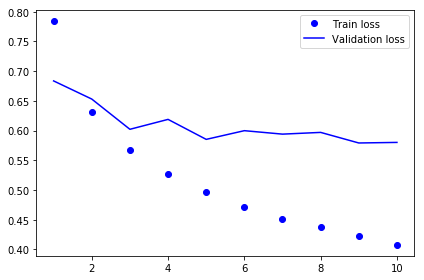

In [146]:
eval_metric(glove_history, 'loss')

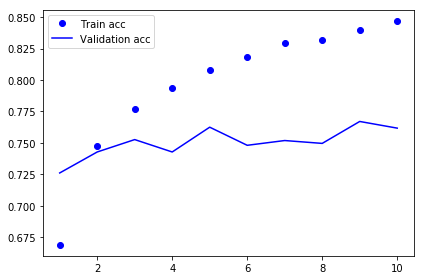

In [147]:
eval_metric(glove_history, 'acc')

In [149]:
glove_results = test_model(glove_model, x_train_seq_trunc, y_train_oh, x_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

1464/1464 [==============================] - 0s 44us/step
/n
Test accuracy of word glove model: 76.23%


In [151]:
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(number_word, glove_dim, input_length=max_len))
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(3, activation='softmax'))
emb_history2 = deep_model(emb_model2, x_train_emb, y_train_emb, x_valid_emb, y_valid_emb)

/home/guerramarj/packages/anaconda3/envs/deeplearning/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


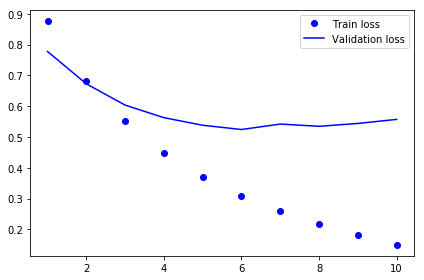

In [152]:
eval_metric(emb_history2, 'loss')

In [154]:
emb_results2 = test_model(emb_model2, x_train_seq_trunc, y_train_oh, x_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word embedding model 2: {0:.2f}%'.format(emb_results2[1]*100))

1464/1464 [==============================] - 0s 41us/step
/n
Test accuracy of word embedding model 2: 80.40%


In [138]:
suicide_data = pd.read_csv(Path(data_path, 'risk_title_body.csv'))
suicide_data.head()

,risk_label,title_body
0,a,"My first spoken word gig, contains rhythmic Co..."
1,a,My first spoken word gig. Warning: contains rh...
2,a,"Me, the boy who first showed me what love was ..."
3,a,Being Proud @ NYC Pride 2010nan
4,a,I wish this guy had been at my high school...nan


In [139]:
suicide_data['text'] = suicide_data.title_body.apply(preprocess_tweet)
suicide_data.head()

,risk_label,title_body,text
0,a,"My first spoken word gig, contains rhythmic Co...",my first spoken word gig contains rhythmic com...
1,a,My first spoken word gig. Warning: contains rh...,my first spoken word gig warning contains rhyt...
2,a,"Me, the boy who first showed me what love was ...",me the boy who first showed me what love was and
3,a,Being Proud @ NYC Pride 2010nan,being proud nyc pride
4,a,I wish this guy had been at my high school...nan,i wish this guy had been at my high school nan


In [140]:
x_text_suic, y_class_suic = load_data_and_labels(file_path=data_path)
sentences_padded, sequence_length = pad_sentences(x_text)
vocabulary, vocabulary_inv = build_vocab(sentences_padded)
number_word_suic = len(vocabulary_inv)